# Brain Tumor Detection using CNN

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd /gdrive/MyDrive/Brain_Tumor/

/gdrive/MyDrive/Brain_Tumor


In [ ]:
%ls

brain_tumor_dataset.zip  DL_Project_Brain_Tumor_Image_Classification.ipynb  Execution_data/


### Data Extraction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import *
%matplotlib inline

In [ ]:
Main_Folder_name = "Execution_data"
if os.path.isdir(Main_Folder_name):
  shutil.rmtree(Main_Folder_name)
  print("Deleted all Previous execution Data")

Deleted all Previous execution Data


In [ ]:
# Dataset
import zipfile

z = zipfile.ZipFile('brain_tumor_dataset.zip')

os.mkdir(Main_Folder_name)
os.chdir(Main_Folder_name)

z.extractall()


In [ ]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [ ]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


In [ ]:
# EDA(Exploratory Data Analysis)

In [ ]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


### Data Preprocessing

In [ ]:
# Plot

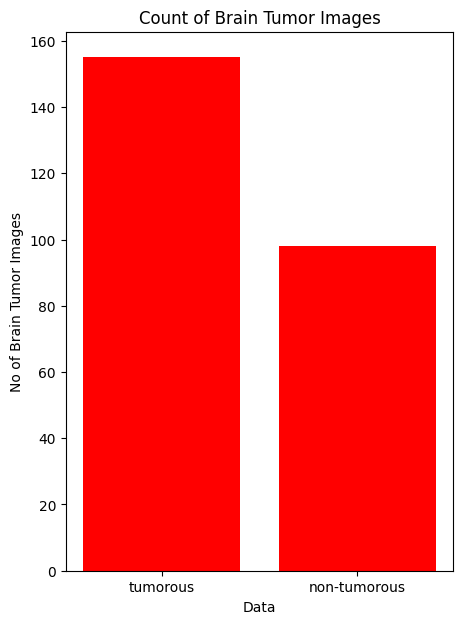

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:
# Data Augmentation
# 155(61%), 98(39%)
# imbalance

### Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [ ]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [ ]:
import time
start_time = time.time()

yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

if not os.path.isdir(augmented_data_path):
  os.mkdir(augmented_data_path)
if not os.path.isdir(augmented_data_path + 'yes'):
  os.mkdir(augmented_data_path + 'yes')
if not os.path.isdir(augmented_data_path + 'no'):
  os.mkdir(augmented_data_path + 'no')

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:54.88352918624878


In [ ]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [ ]:
data_summary(augmented_data_path)

Number of sample: 2064
1084 Number of positive sample in percentage: 52.51937984496124%
980 Number of negative sample in percentage: 47.48062015503876%


In [ ]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1084
980


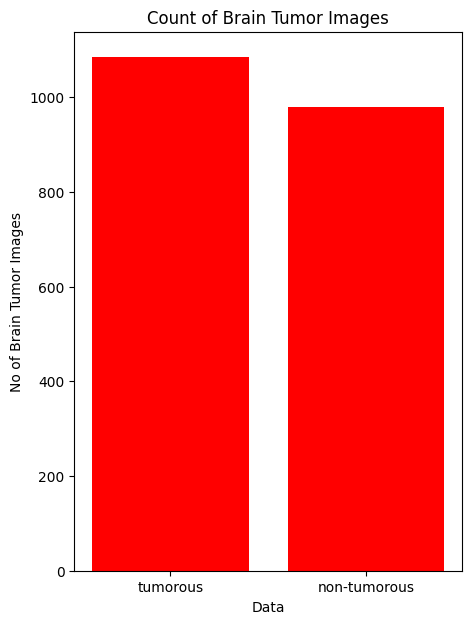

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:
# Data Preprocessing

In [ ]:
# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

### Skull Stripping

In [ ]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image


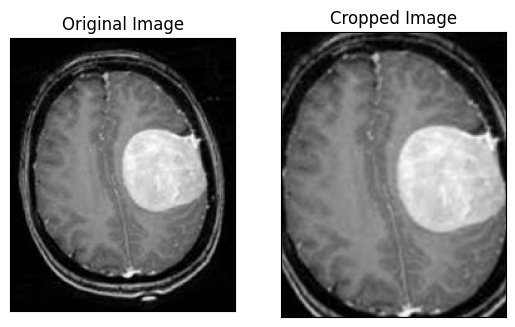

array([[[ 1,  1,  1],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 5,  5,  5],
        [ 6,  6,  6],
        [ 6,  6,  6]],

       [[ 0,  0,  0],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 4,  4,  4],
        [ 5,  5,  5],
        [ 7,  7,  7]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 3,  3,  3],
        [ 5,  5,  5],
        [ 7,  7,  7]],

       ...,

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 7,  7,  7],
        [ 1,  1,  1],
        [ 0,  0,  0]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 5,  5,  5],
        [ 3,  3,  3],
        [ 4,  4,  4]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 9,  9,  9],
        [10, 10, 10],
        [ 9,  9,  9]]], dtype=uint8)
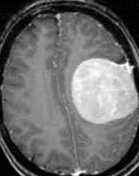

In [ ]:
img = cv2.imread('augmented_data/yes/' + os.listdir('augmented_data/yes/')[0])
crop_brain_tumor(img, True)

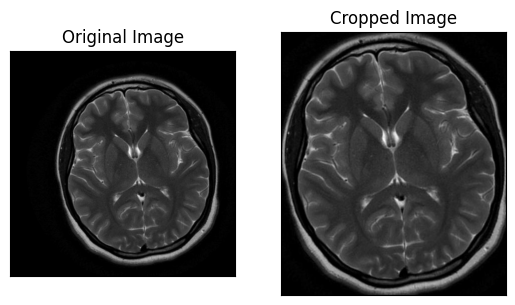

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
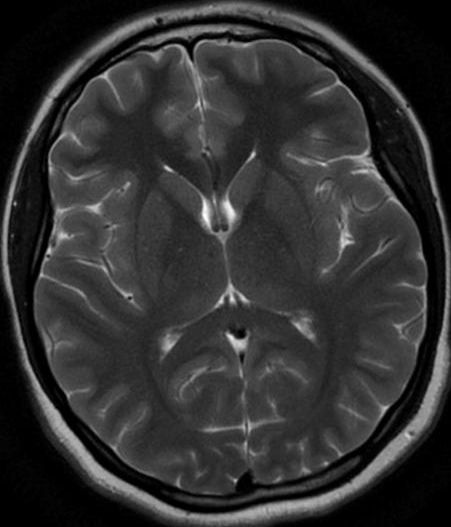

In [ ]:
img = cv2.imread('augmented_data/no/' + os.listdir('augmented_data/no/')[0])
crop_brain_tumor(img, True)

In [ ]:
# image loading

In [ ]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            cv2.imwrite( directory + '/' + filename, image )
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y


In [ ]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2064
X SHAPE is : (2064, 240, 240, 3)
y SHAPE is : (2064,)


In [ ]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

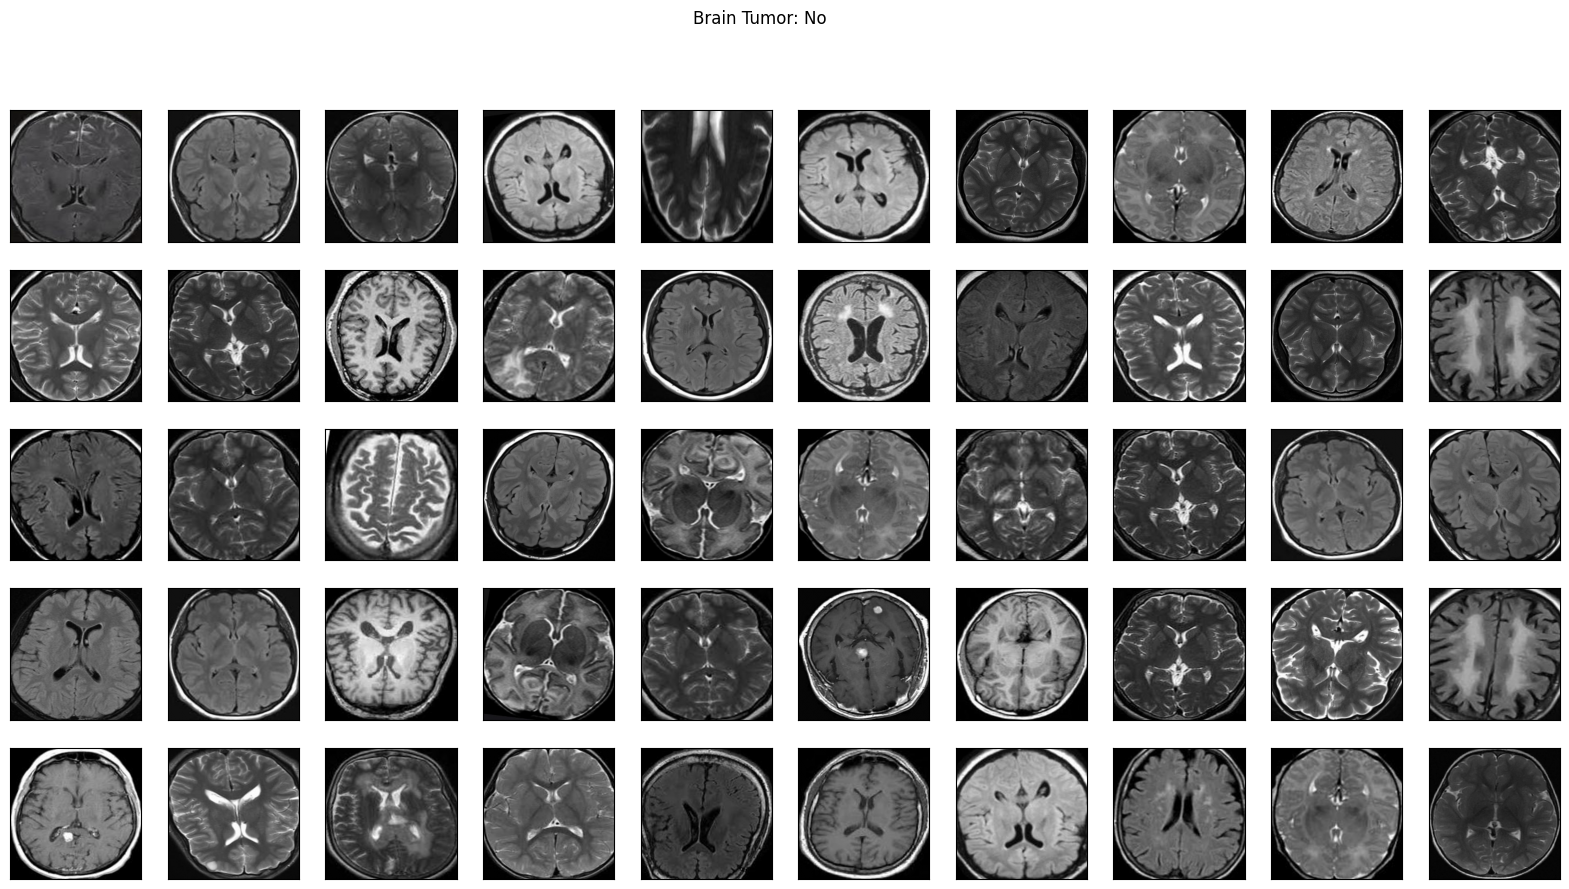

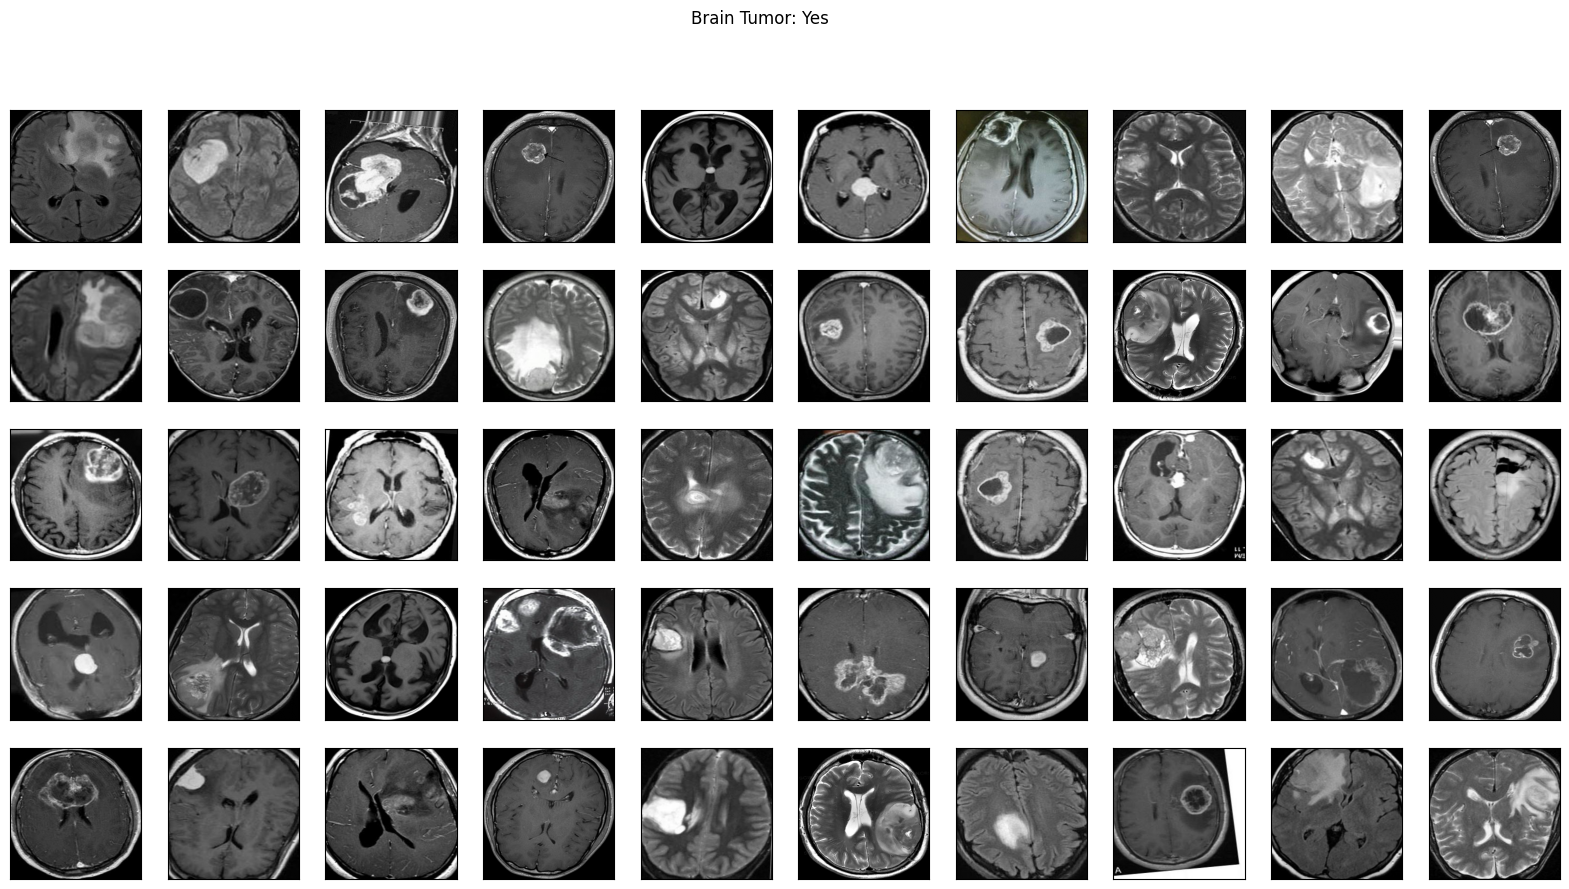

In [ ]:
plot_sample_images(X,y)

In [ ]:
# Data Spliting
# Train
# Test
# Validation

### Splitting Data into Train , Test and Validation

In [ ]:
X_train , X_test , y_train , y_test = train_test_split( X , y , test_size = 0.2 , shuffle = True , random_state = 0 )

In [ ]:
X_train , X_val , y_train , y_val = train_test_split( X_train , y_train , test_size = 0.1 , shuffle = True , random_state = 0 )

In [ ]:
del z
del X
del y

In [ ]:
# Model Buliding

In [ ]:
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.layers import BatchNormalization
from keras.utils import to_categorical

In [ ]:
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)
print(y_train)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [ ]:
print(f"Train size = {len(X_train)}")
print(f"Validaton size = {len(X_val)}")
print(f"Test size = {len(X_test)}")

Train size = 1485
Validaton size = 166
Test size = 413


### Model Prepration

---



*   Loading Pre-trained Model VGG19
*   Adding Fully Connected Layers to the Model Architecture







In [ ]:
base_Neural_Net= VGG19(input_shape=(240,240,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                         

In [ ]:
# callback
filepath = 'model.h5'
es1 = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=5)
es2 = EarlyStopping(monitor='val_acc',mode='max',patience=5)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

### Tranfer Learning

---

*   Training it for 10 epochs




In [ ]:
EPOCHS = 10

history = model.fit(
    X_train , y_train,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data= (X_val , y_val),
    callbacks=[es1,es2,cp,lrr]
)

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.8579 - auc: 0.9226


Epoch 1: val_loss improved from inf to 0.35597, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 39s 515ms/step - loss: 0.3856 - accuracy: 0.8579 - auc: 0.9226 - val_loss: 0.3560 - val_accuracy: 0.8133 - val_auc: 0.9192 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9670 - auc: 0.9939


Epoch 2: val_loss improved from 0.35597 to 0.26018, saving model to model.h5


50/50 [==============================] - 10s 204ms/step - loss: 0.1020 - accuracy: 0.9670 - auc: 0.9939 - val_loss: 0.2602 - val_accuracy: 0.8855 - val_auc: 0.9679 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9926 - auc: 0.9998


Epoch 3: val_loss improved from 0.26018 to 0.17216, saving model to model.h5


50/50 [==============================] - 10s 209ms/step - loss: 0.0380 - accuracy: 0.9926 - auc: 0.9998 - val_loss: 0.1722 - val_accuracy: 0.9518 - val_auc: 0.9921 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9933 - auc: 0.9997


Epoch 4: val_loss improved from 0.17216 to 0.16254, saving model to model.h5


50/50 [==============================] - 11s 213ms/step - loss: 0.0284 - accuracy: 0.9933 - auc: 0.9997 - val_loss: 0.1625 - val_accuracy: 0.9277 - val_auc: 0.9869 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9993 - auc: 1.0000


Epoch 5: val_loss improved from 0.16254 to 0.09005, saving model to model.h5


50/50 [==============================] - 10s 210ms/step - loss: 0.0117 - accuracy: 0.9993 - auc: 1.0000 - val_loss: 0.0901 - val_accuracy: 0.9699 - val_auc: 0.9976 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9973 - auc: 1.0000


Epoch 6: val_loss improved from 0.09005 to 0.06969, saving model to model.h5


50/50 [==============================] - 11s 213ms/step - loss: 0.0106 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.0697 - val_accuracy: 0.9759 - val_auc: 0.9983 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 1.0000 - auc: 1.0000


Epoch 7: val_loss improved from 0.06969 to 0.06921, saving model to model.h5


50/50 [==============================] - 11s 225ms/step - loss: 0.0083 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0692 - val_accuracy: 0.9639 - val_auc: 0.9981 - lr: 0.0010
Epoch 8/10
50/50 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9987 - auc: 1.0000


Epoch 8: val_loss improved from 0.06921 to 0.05980, saving model to model.h5


50/50 [==============================] - 11s 224ms/step - loss: 0.0067 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.0598 - val_accuracy: 0.9699 - val_auc: 0.9984 - lr: 0.0010
Epoch 9/10
50/50 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9973 - auc: 0.9999


Epoch 9: val_loss did not improve from 0.05980


50/50 [==============================] - 10s 205ms/step - loss: 0.0115 - accuracy: 0.9973 - auc: 0.9999 - val_loss: 0.0635 - val_accuracy: 0.9819 - val_auc: 0.9967 - lr: 0.0010
Epoch 10/10
50/50 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9973 - auc: 1.0000


Epoch 10: val_loss improved from 0.05980 to 0.05029, saving model to model.h5


50/50 [==============================] - 11s 216ms/step - loss: 0.0088 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.0503 - val_accuracy: 0.9759 - val_auc: 0.9987 - lr: 0.0010


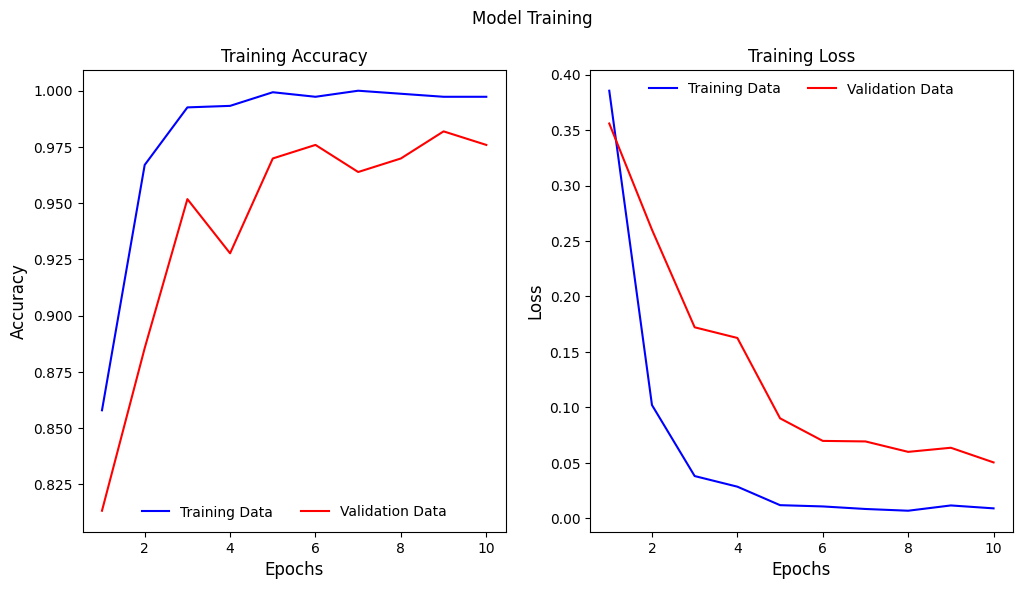

In [ ]:
# # Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training", fontsize=12)
max_epoch = len(history.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
labels = [ 'non-tumorous' , 'tumorous' ]

In [ ]:
predictions = model.predict(X_train)

predictions=np.argmax(predictions, axis=1)
y_train=np.argmax(y_train, axis=1)

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

47/47 [==============================] - 12s 262ms/step
Train Accuracy = 1.00


### Confusion Matrix For Training Data

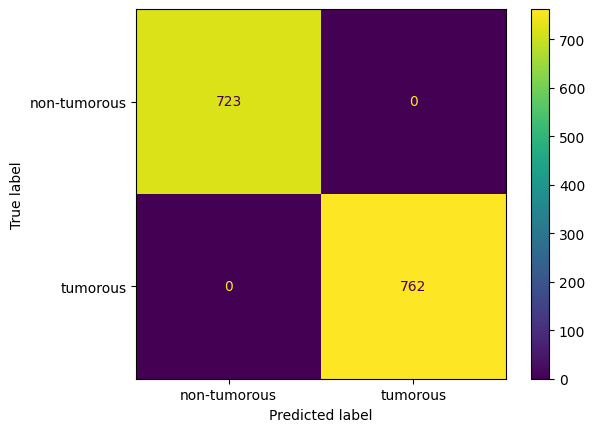

In [ ]:
confusion_mtx = confusion_matrix(y_train, predictions)
ConfusionMatrixDisplay(confusion_mtx, display_labels=labels).plot()

In [ ]:
predictions = model.predict(X_val)

predictions = np.argmax(predictions, axis=1)
y_val = np.argmax(y_val, axis=1)

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

6/6 [==============================] - 1s 177ms/step
Val Accuracy = 0.98


### Confusion Matrix For Validation Data

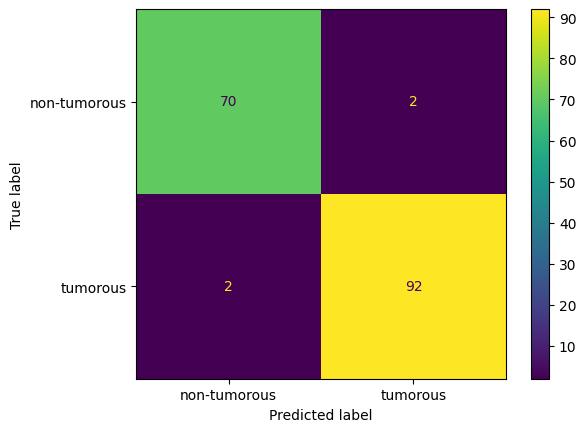

In [ ]:
confusion_mtx = confusion_matrix(y_val, predictions)
ConfusionMatrixDisplay(confusion_mtx, display_labels=labels ).plot()

In [ ]:
# validate on test set
predictions = model.predict(X_test)

predictions=np.argmax(predictions, axis=1)
y_test=np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

13/13 [==============================] - 9s 775ms/step
Test Accuracy = 0.98


### Confusion Matrix For Test Data

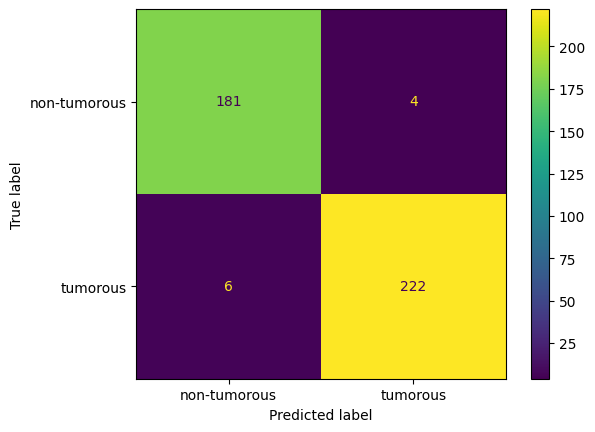

In [ ]:
confusion_mtx = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_mtx ,display_labels=labels).plot()

### Accuracy Matrices for Test Data

*  accuracy_score
*  precision_score
*  recall_score
*  f1_score





In [ ]:
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, predictions))
print('Precision score is :', metrics.precision_score(y_test, predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, predictions, average='weighted'))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.9757869249394673
Precision score is : 0.9758565929610319
Recall score is : 0.9757869249394673
F1 Score is : 0.9757986810864697
		Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       185
           1       0.98      0.97      0.98       228

    accuracy                           0.98       413
   macro avg       0.98      0.98      0.98       413
weighted avg       0.98      0.98      0.98       413

